# KNN算法实现与聚类实例

### 本节主要介绍KNN算法，以及用KNN实现鸢尾花的分类，使用KNN解决聚类问题.

### 参考：
算法实现 https://www.bilibili.com/video/BV1V7411P7wL

数据集来源 https://www.kaggle.com/datasets/uciml/iris

# 1.数据预处理
### 首先导入数据，初步清理数据

In [4]:
import numpy as np
import pandas as pd
#!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple --upgrade pandas

In [5]:
data  = pd.read_csv('\data\Iris.csv', header = 0)
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
data.isnull().count()

Id               150
SepalLengthCm    150
SepalWidthCm     150
PetalLengthCm    150
PetalWidthCm     150
Species          150
dtype: int64

### 可以看到数据是比较干净的，没有null项。接下来用映射map处理一下species类

In [7]:
data['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [8]:
data['Species'] = data['Species'].map({'Iris-setosa' : 0, 'Iris-versicolor' : 1, 'Iris-virginica' : 2})
data['Species'].head()

0    0
1    0
2    0
3    0
4    0
Name: Species, dtype: int64

### 删除id列因为没用，删除重复项

In [9]:
data.drop('Id', axis = 1, inplace = True)

In [10]:
data.duplicated().any()

True

In [11]:
data = data.drop_duplicates() #注意函数名叫drop_duplicates不是drop_duplicated
len(data)

147

In [12]:
data['Species'].value_counts()

1    50
2    49
0    48
Name: Species, dtype: int64

# 2. KNN算法

In [13]:
class KNN:
    """
    K近邻算法，实现分类
    """
    def __init__(self , k):
        """初始化，k表示选择k个邻居"""
        self.k = k
    
    def fit(self, X, y):
        """
        X：类数组类型，shape：[样本数量，特征数量]
        y：类数组类型，shape：[样本数量]
        """
        self.X = np.asarray(X)
        self.y = np.asarray(y)
        
    def predict(self, X):
        """ return一个数组类型，预测的结果"""
        X = np.asarray(X)
        result = []
        
        for x in X:
            dis = np.sqrt(np.sum((x - self.X) ** 2, axis = 1))
            index = dis.argsort()  
            # 返回的是排序后元素对应排序前的位置index，注意这里的排序是从小到大排序，且获得的index是从0开始
            index = index[ :self.k]
            #self.y[index]后会得到最近的k个点的对应的类别
            #见说明[1]
            count = np.bincount(self.y[index])
            #见说明[2]
            result.append(count.argmax())
        return np.asarray(result)  
            
    def predict2(self, X):
        """优化聚类方式，使用距离倒数作为权重，即点离得越近，越是跟那个点的类型接近"""
        X = np.asarray(X)
        result = []
        
        for x in X:
            dis = np.sqrt(np.sum((x - self.X) ** 2, axis = 1))
            index = dis.argsort()  
            index = index[:self.k]
            count = np.bincount(self.y[index], weights = 1/ dis[index])
            result.append(count.argmax())
        return np.asarray(result)  

说明：
* [1]bincount返回数组中每个元素出现的次数，元素必须是非负整数，返回的是一个长数组，表示0到max出现的次数。感觉这个很费内存啊。
* [2]使用argmax()，表示k个近邻点的类别里，数量最大的那个类别作为这个点的类别。当然这里可以使用加权等其他的方法作为判断点的类别。

# 3.分开训练集和验证集

In [14]:
t0 = data[data['Species'] == 0]
t1 = data[data['Species'] == 1]
t2 = data[data['Species'] == 2]

seed = 42
t0 = t0.sample(len(t0), random_state = seed)
t1 = t1.sample(len(t1), random_state = seed)
t2 = t2.sample(len(t2), random_state = seed)

t0.shape,t1.shape,t2.shape

((48, 5), (50, 5), (49, 5))

In [15]:
train_X = pd.concat([t0.iloc[:40, :-1], t1.iloc[:40, :-1],  t2.iloc[:40, :-1]], axis = 0)
train_y = pd.concat([t0.iloc[:40, -1], t1.iloc[:40, -1],  t2.iloc[:40, -1]], axis = 0)
test_X = pd.concat([t0.iloc[40:, :-1], t1.iloc[40:, :-1],  t2.iloc[40:, :-1]], axis = 0) 
test_y = pd.concat([t0.iloc[40:, -1], t1.iloc[40:, -1],  t2.iloc[40:, -1]], axis = 0) 

train_X.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
27,5.2,3.5,1.5,0.2
42,4.4,3.2,1.3,0.2
26,5.0,3.4,1.6,0.4
45,4.8,3.0,1.4,0.3
24,4.8,3.4,1.9,0.2


# 4.训练和预测

In [16]:
knn = KNN(k =3)
knn.fit(train_X, train_y)
result = knn.predict(test_X)

display(np.sum(result == test_y))
display(len(test_y))
display(np.sum(result == test_y) / len(result))

26

27

0.9629629629629629

In [17]:
knn = KNN(k=3)
knn.fit(train_X, train_y)
result2 = knn.predict2(test_X)
display(np.sum(result2 == test_y))
display(len(test_y))
display(np.sum(result2 == test_y)/len(result2))

26

27

0.9629629629629629

# 5.可视化

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'SimHei'
mpl.rcParams['axes.unicode_minus'] = False #在中文中正常显示符号
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #指定输出svg图片，否则清晰度太低了

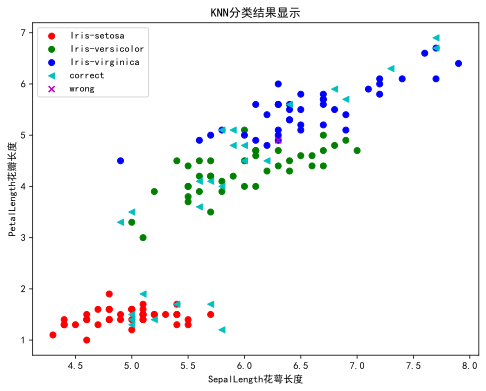

In [19]:
#'Iris-setosa' : 0, 'Iris-versicolor' : 1, 'Iris-virginica' : 2
plt.figure(figsize =(8,6) ) #指定画布大小
plt.scatter(x = t0['SepalLengthCm'][:40], y =t0['PetalLengthCm'][:40], color = 'r', label ='Iris-setosa')
plt.scatter(x = t1['SepalLengthCm'][:40], y =t1['PetalLengthCm'][:40], color = 'g', label ='Iris-versicolor')
plt.scatter(x = t2['SepalLengthCm'][:40], y =t2['PetalLengthCm'][:40], color = 'b', label ='Iris-virginica' )

correct = test_X[result == test_y]
wrong = test_X[result != test_y]
plt.scatter(x = correct['SepalLengthCm'][:40], y =correct['PetalLengthCm'][:40], color = 'c', marker = '<', label = 'correct')
plt.scatter(x = wrong['SepalLengthCm'][:40], y =wrong['PetalLengthCm'][:40], color = 'm', marker = 'x', label = 'wrong')

plt.xlabel('SepalLength花萼长度')
plt.ylabel('PetalLength花瓣长度')
plt.title('KNN分类结果显示')
plt.legend()
plt.show()